# Benchmarking S3 performance with pywren and AWS Lambda


In [1]:
%pylab inline
import numpy as np
import time
import s3_benchmark
import pandas as pd
import pickle
import seaborn as sns
sns.set_style('whitegrid')


Populating the interactive namespace from numpy and matplotlib


## Getting Started 

We are going to benchmark S3 by writing a large amount of data to a bucket, and then reading that data back. I created a bucket, `jonas-pywren-benchmark`, specifically for this purpose. 

In [26]:
!python s3_benchmark.py write --bucket_name=jonas-pywren-benchmark --mb_per_file=100 \
--number=1000 --outfile=write.pickle

We then run the read test

In [27]:
!python s3_benchmark.py read --key_file=write.pickle --outfile=read.pickle

We pick some default consistent colors, and set up some code for preprocessing the results

In [28]:
current_palette = sns.color_palette()
read_color = current_palette[0]
write_color = current_palette[1]

runtime_bins = np.linspace(0, 150, 150)

    
def compute_times_rates(d):
    
    x = np.array(d)
    tzero = np.min(x[:, 0])
    start_time = x[:, 0] - tzero
    end_time = x[:, 1]  - tzero
    rate = x[:, 2]

    N = len(start_time)

    runtime_rate_hist = np.zeros((N, len(runtime_bins)))
    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    for i in range(N):
        s = start_time[i]
        e = end_time[i]
        a, b = np.searchsorted(runtime_bins, [s, e])
        if b-a > 0:
            runtime_rate_hist[i, a:b] = rate[i]
            runtime_jobs_hist[i, a:b] = 1

    return {'start_time' : start_time, 
            'end_time' : end_time, 
            'rate' : rate, 
            'runtime_rate_hist' : runtime_rate_hist, 
            'runtime_jobs_hist' : runtime_jobs_hist}

write_data = pickle.load(open("write.pickle", 'rb'))
write = compute_times_rates(write_data['results'])

read_data = pickle.load(open("read.pickle", 'rb'))
read_time_results = [r[:3] for r in read_data['results']]
read  = compute_times_rates(read_time_results)


What is the distribution of read and write rates to S3 from our 2000 lambdas?

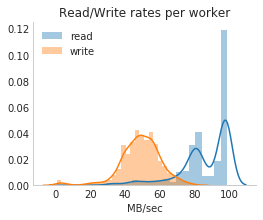

In [29]:
fig = pylab.figure(figsize=(4, 3))
sns.distplot(read['rate'], label='read', color=read_color)
sns.distplot(write['rate'], label='write', color=write_color)
pylab.legend()
pylab.xlabel("MB/sec")
pylab.grid(False)
pylab.title("Read/Write rates per worker")
fig.savefig("s3_benchmark.rates.png")
sns.despine()
fig.savefig("s3_benchmark.rates.png")

We can investigate when jobs start and how long they run. Each horizontal line is a job, and then plotted on top is the aggregate number of jobs running at that moment. 

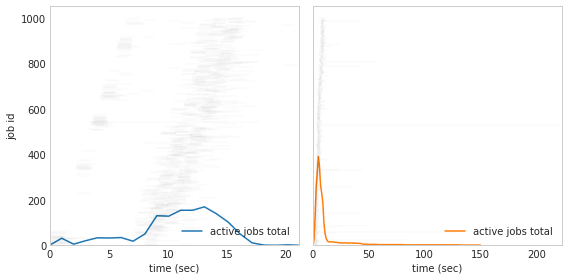

In [30]:
from matplotlib.collections import LineCollection

    
fig = pylab.figure(figsize=(8, 4))

for plot_i, (datum, l, c) in enumerate([(read, 'read', read_color), 
                                    (write, 'write', write_color)]):
    ax = fig.add_subplot(1, 2, 1 + plot_i)

    N = len(datum['start_time'])
    line_segments = LineCollection([[[datum['start_time'][i], i], 
                                     [datum['end_time'][i], i]] for i in range(N)],
                                   linestyles='solid', color='k', alpha=0.05, linewidth=0.4)
    #line_segments.set_array(x)

    ax.add_collection(line_segments)

    ax.plot(runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), 
            c=c, label='active jobs total', 
           zorder=-1)


    ax.set_xlim(0, np.max(datum['end_time']))
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    ax.set_xlabel("time (sec)")
    if plot_i == 0:
        ax.set_ylabel("job id")
    else:
        ax.set_yticks([])
    ax.grid(False)
    ax.legend(loc='lower right')
fig.tight_layout()
fig.savefig("s3_benchmark.workers.png")

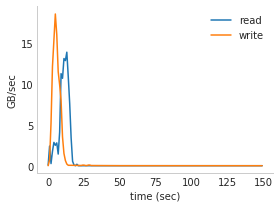

In [31]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
for d, l, c in [(read, 'read', read_color), (write, 'write', write_color)]:
    
    ax.plot(d['runtime_rate_hist'].sum(axis=0)/1000, label=l, c=c)
ax.set_xlabel('time (sec)')
ax.set_ylabel("GB/sec")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()
fig.savefig("s3_benchmark.tput.png")